# Defining trait space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import cmocean
import constants
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Load traits database

A subset of the trait data from {cite:t}`Deutsch-Penn-etal-2020`, including only the marine organisms for which temerature-dependent hypoxia metabolic traits have been determined. 

The `open_traits_df` function is defined in the [metabolic](https://github.com/matt-long/aerobic-safety-margins/blob/main/notebooks/metabolic.py) module and  makes the trait data available via a [pandas](https://pandas.pydata.org/) `DataFrame`.

In [5]:
df = mi.open_traits_df(add_ATmax=True)
df

,Species,Phylum,alphaD_log10,Emet,Eo,Ao,Ac,Phi_crit,ATmax_active,ATmax_resting
0,Acanthephyra acutifrons,Crustacea,0.479565,0.040200,-0.027836,0.264715,0.131959,2.006040,34.514806,40.311588
1,Acanthephyra curtirostris,Crustacea,0.377714,0.043938,0.038027,0.252578,0.141861,1.780456,33.652163,38.409878
2,Acanthephyra purpurea,Crustacea,1.035748,0.840722,0.131972,0.230068,0.073638,3.124330,24.570359,35.661192
3,Acanthephyra smithi,Crustacea,1.082577,0.313173,-0.030067,0.286307,0.174423,1.641453,37.061791,40.943719
4,Acipenser brevirostrum,Chordata,NaN,NaN,0.362569,0.218524,0.048415,4.513525,15.478736,31.110696
...,...,...,...,...,...,...,...,...,...,...
56,Styela plicata,Tunicata,0.433791,0.346635,-0.190998,0.061336,0.043505,1.409863,NaN,29.736384
57,Systellaspis debilis,Crustacea,0.779626,0.418652,0.226970,0.219289,0.096003,2.284196,26.145349,33.440377
58,Tarletonbeania crenularis,Chordata,NaN,NaN,0.213307,0.203696,0.051780,3.933876,17.478188,33.126090
59,Tautogolabrus adspersus,Chordata,0.801974,0.327012,0.244520,0.170886,0.051204,3.337395,17.015458,31.162552


## Illustrating trait distributions

Recall the definition of the [Metabolic Index](./metabolic-index-defining.ipynb):

$$
  \Phi = A_o \frac{P_{\mathrm{O}_2}}
  {\mathrm{exp}\left[
  \frac{-E_o}{k_B}\left(
  \frac{1}{T} - \frac{1}{T_{ref}}
  \right)
  \right]
  }
$$


Parameters relevant to defining trait space:
- $E_o$: Temperature sensitivity of metabolic rates.
- $A_o$: Hypoxic tolerance for resting metabolism.
- $\Phi_{crit}$: lowest value of Metabolic Index at which *active* metabolism can be sustained.

Since active metabolism requires $\Phi >= \Phi_{crit}$, we can directly compute values of the Metabolic Index relevant for active metabolic rates, defining a new parameter:
- $A_c$: Hypoxic tolerance for active metabolism (i.e., $A_o / \Phi_{crit}$)


The hidden code below defines a function for plotting trait histograms.

In [4]:
def plot_trait_hist(df, trait):
    fig, ax = plt.subplots()

    pdf = mi.trait_pdf(df, trait, 30)
    beta = pdf.beta
    trait_median = pdf.median()

    trait_values = df[trait].values
    if trait in pdf.normal_traits:
        n, bins, h = ax.hist(trait_values, 30, density=True)
    else:
        log10_values = np.log10(trait_values)
        n, bins, h = ax.hist(
            trait_values, np.logspace(log10_values.min(), log10_values.max(), 30), density=True
        )

    ax.plot(pdf.coord, pdf.fitted())
    ax.set_title(f'{trait} distribution')
    ax.set_xlabel(f"df[trait].attrs['long_name'] {df[trait].attrs['units']}")

    ax.axvline(trait_median, color='black', label=f'median ({trait_median:0.3f})')

    ax.legend()
    return trait_median, beta

The following plots illustrate trait distributions. 

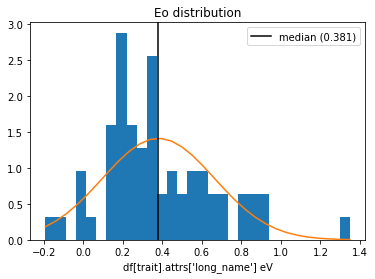

In [5]:
Eo_med, Eo_beta = plot_trait_hist(df, 'Eo')

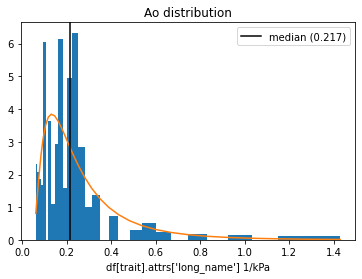

In [6]:
Ao_med, Ao_beta = plot_trait_hist(df, 'Ao')

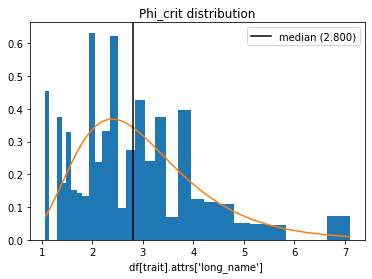

In [7]:
Phi_crit_med, Phi_crit_beta = plot_trait_hist(df, 'Phi_crit')

These individual traits can be combined into a joint probability distribution defining a "metabolic trait space." Here we illustrate an idealized version of this trait space, fitting a normal distribution to $E_o$ and a lognormal distribution to $A_c = A_o/\Phi_{crit}$.

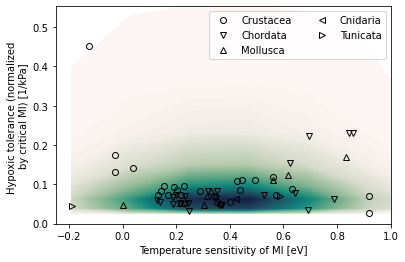

In [8]:
markerorder = ["o", "v", "^", "<", ">", "s", "p", "P"]

Phyla = list(df.Phylum.unique())

Eo_fit = mi.trait_pdf(df, 'Eo', 8, [df.Eo.min(), df.Eo.max()])
Ac_fit = mi.trait_pdf(df, 'Ac', 8, [df.Ac.min(), df.Ac.max()])

# Eo_bins = np.linspace(-1.0, 2.0, 30)
# Ac_bins = np.logspace(-3, np.log10(df.Ac.max()), 50)

X, Y = np.meshgrid(Eo_fit.coord, Ac_fit.coord)
Z1, Z2 = np.meshgrid(Eo_fit.fitted(), Ac_fit.fitted())

fig, ax = plt.subplots()  # figsize=(6, 6))

mx = np.max(Z1 * Z2)
cf = ax.contourf(
    X,
    Y,
    Z1 * Z2 / mx,
    cmap=cmocean.cm.tempo,
    levels=np.arange(0.001, 1.02, 0.01),
)


for i, phylum in enumerate(Phyla):
    ndx = df.Phylum == phylum
    ax.plot(
        df.Eo.loc[ndx],
        df.Ac.loc[ndx],
        linestyle='none',
        marker=markerorder[i],
        color='k',
        markerfacecolor='none',
        label=phylum,
    )

ax.set_xlabel(util.attrs_label(df.Eo.attrs))
ax.set_ylabel(util.attrs_label(df.Ac.attrs))

ax.set_xlim((-0.25, 1))
# ax.set_ylim((0, 0.4));

ax.legend(ncol=2)
plt.savefig(f'figures/misc/trait-space-idealized.png', dpi=300)

## Define the trait space for analysis

Trait space can be thought of something like an integration kernel, which enables computing the net capacity of the ocean to support aerobic metabolism, inclusive of the trait density distribution for ecothermic organisms. 

In the sequence of operations below, we build two versions of the idealized trait space distribution:
- a low resolution (in trait space) version enabling analysis with the Earth system model;
- a high resolution version for more refined assessments of habitat and trait variability.

### Define trait-coordinates 

<xarray.DataArray 'Ac' (Ac: 8)>
array([0.0258, 0.0399, 0.0619, 0.0959, 0.1486, 0.2303, 0.3568, 0.5528])
Coordinates:
  * Ac       (Ac) float64 0.0258 0.0399 0.0619 0.0959 ... 0.2303 0.3568 0.5528
Attributes:
    long_name:  Hypoxic tolerance (normalized by critical MI)
    units:      1/kPa

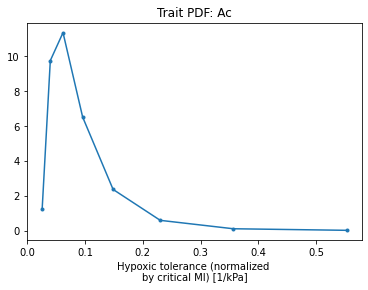

In [9]:
obj_Ac_pdf = mi.trait_pdf(df, 'Ac', 8, [df.Ac.min(), df.Ac.max()])
plt.plot(obj_Ac_pdf.coord, obj_Ac_pdf.fitted(), '.-')
plt.title('Trait PDF: Ac')
plt.xlabel(util.attrs_label(df.Ac.attrs))
obj_Ac_pdf.coord

<xarray.DataArray 'Ao' (Ao: 8)>
array([0.0613, 0.0962, 0.1508, 0.2364, 0.3707, 0.5813, 0.9114, 1.4291])
Coordinates:
  * Ao       (Ao) float64 0.0613 0.0962 0.1508 0.2364 0.3707 0.5813 0.9114 1.429
Attributes:
    long_name:  Hypoxic tolerance
    units:      1/kPa

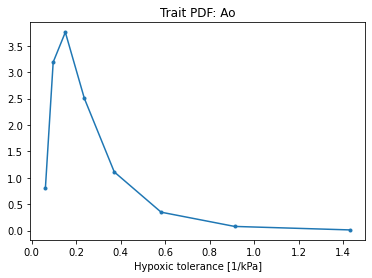

In [10]:
obj_Ao_pdf = mi.trait_pdf(df, 'Ao', 8, [df.Ao.min(), df.Ao.max()])
plt.plot(obj_Ao_pdf.coord, obj_Ao_pdf.fitted(), '.-')
plt.title('Trait PDF: Ao')
plt.xlabel(util.attrs_label(df.Ao.attrs))
obj_Ao_pdf.coord

<xarray.DataArray 'Eo' (Eo: 7)>
array([-0.2, -0. ,  0.2,  0.4,  0.6,  0.8,  1. ])
Coordinates:
  * Eo       (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
Attributes:
    long_name:  Temperature sensitivity of MI
    units:      eV

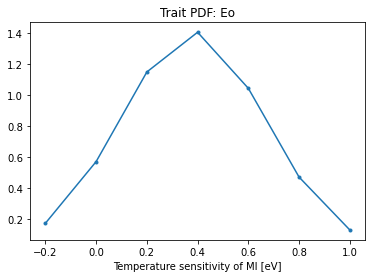

In [11]:
obj_Eo_pdf = mi.trait_pdf(df, 'Eo', 7, [-0.2, 1.0])
plt.plot(obj_Eo_pdf.coord, obj_Eo_pdf.fitted(), '.-')
plt.title('Trait PDF: Eo')
plt.xlabel(util.attrs_label(df.Eo.attrs))
obj_Eo_pdf.coord

### Generate a low-resolution trait space

In [12]:
def gen_trait_space(obj_Ac_pdf, obj_Ao_pdf, obj_Eo_pdf):
    dso = xr.Dataset()

    # active metabolism
    dso['trait_spc_active'] = xr.DataArray(
        obj_Ac_pdf.fitted(), dims=('Ac'), coords={'Ac': obj_Ac_pdf.coord}
    ) * xr.DataArray(obj_Eo_pdf.fitted(), dims=('Eo'), coords={'Eo': obj_Eo_pdf.coord})
    dso['trait_spc_active'] = dso.trait_spc_active / dso.trait_spc_active.sum()
    np.testing.assert_almost_equal(dso.trait_spc_active.sum(), 1.0)

    dso.trait_spc_active.attrs['long_name'] = 'Trait density (active)'
    dso.trait_spc_active.attrs['units'] = ' '.join([obj_Eo_pdf.coord.units, obj_Ac_pdf.coord.units])
    dso.trait_spc_active.attrs['metabolic_baseline'] = 'active'
    dso.trait_spc_active.attrs['N_traits'] = dso.trait_spc_active.size

    # resting metabolism
    dso['trait_spc_resting'] = xr.DataArray(
        obj_Ao_pdf.fitted(), dims=('Ao'), coords={'Ao': obj_Ao_pdf.coord}
    ) * xr.DataArray(obj_Eo_pdf.fitted(), dims=('Eo'), coords={'Eo': obj_Eo_pdf.coord})
    dso['trait_spc_resting'] = dso.trait_spc_resting / dso.trait_spc_resting.sum()
    np.testing.assert_almost_equal(dso.trait_spc_resting.sum(), 1.0)

    dso.trait_spc_resting.attrs['long_name'] = 'Trait density (resting)'
    dso.trait_spc_resting.attrs['units'] = ' '.join(
        [obj_Eo_pdf.coord.units, obj_Ao_pdf.coord.units]
    )
    dso.trait_spc_resting.attrs['metabolic_baseline'] = 'resting'
    dso.trait_spc_resting.attrs['N_traits'] = dso.trait_spc_resting.size

    return dso


dso = gen_trait_space(obj_Ac_pdf, obj_Ao_pdf, obj_Eo_pdf)
dso

<xarray.Dataset>
Dimensions:            (Ac: 8, Eo: 7, Ao: 8)
Coordinates:
  * Ac                 (Ac) float64 0.0258 0.0399 0.0619 ... 0.3568 0.5528
  * Eo                 (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
  * Ao                 (Ao) float64 0.0613 0.0962 0.1508 ... 0.5813 0.9114 1.429
Data variables:
    trait_spc_active   (Ac, Eo) float64 0.001347 0.004475 ... 1.041e-05
    trait_spc_resting  (Ao, Eo) float64 0.002386 0.007927 ... 0.000106 2.896e-05

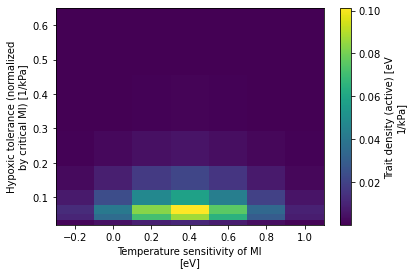

In [13]:
dso.trait_spc_active.plot();

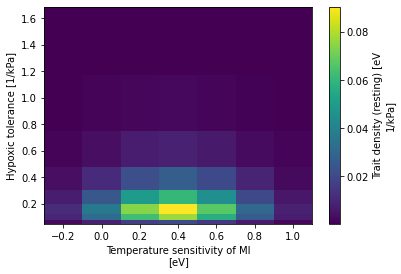

In [14]:
dso.trait_spc_resting.plot();

### Generate a higher resolution version of trait space

In [15]:
dso_hires = gen_trait_space(
    mi.trait_pdf(df, 'Ac', 30),
    mi.trait_pdf(df, 'Ao', 30),
    mi.trait_pdf(df, 'Eo', 30),
)
dso_hires

<xarray.Dataset>
Dimensions:            (Ac: 30, Eo: 30, Ao: 30)
Coordinates:
  * Ac                 (Ac) float64 0.0258 0.0287 0.0319 ... 0.4973 0.5528
  * Eo                 (Eo) float64 -0.191 -0.1379 -0.0848 ... 1.242 1.295 1.348
  * Ao                 (Ao) float64 0.0613 0.0684 0.0762 ... 1.15 1.282 1.429
Data variables:
    trait_spc_active   (Ac, Eo) float64 9.249e-05 0.0001328 ... 2.123e-08
    trait_spc_resting  (Ao, Eo) float64 0.0001659 0.0002381 ... 5.978e-08

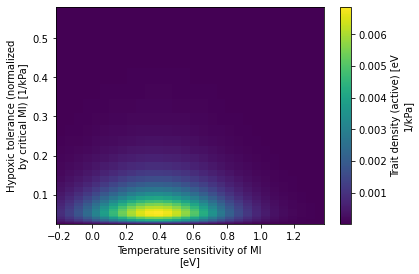

In [16]:
dso_hires.trait_spc_active.plot()

## Solve for maximum metabolic temperature 

Use root finding technique to solve for $AT_{max}$ (the maximum temerature at which metabolism can be sustained) over all traits.

First illustrate computation on a subset of traits.

In [17]:
mi.dEodT_bar

0.022

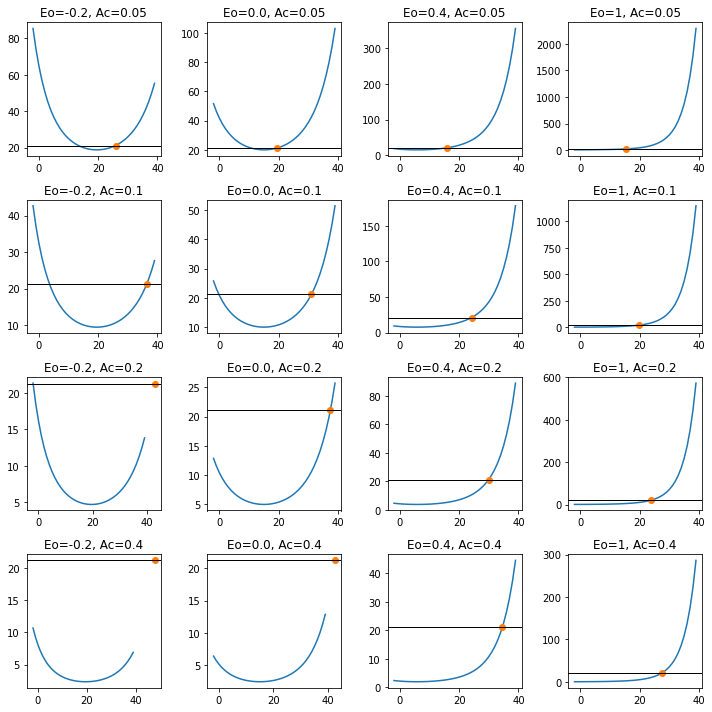

In [18]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

PO2_atm = constants.XiO2 * constants.kPa_per_atm

T = np.arange(-2.0, 40.0, 1.0)

for i, Ac in enumerate([0.05, 0.1, 0.2, 0.4]):
    for j, Eo in enumerate([-0.2, 0.0, 0.4, 1]):
        ax = axs[i, j]
        ATmax_ij = mi.compute_ATmax(PO2_atm, Ac, Eo, dEodT=mi.dEodT_bar)
        ax.plot(T, mi.pO2_at_Phi_one(T, Ac, Eo, dEodT=mi.dEodT_bar), '-')
        ax.plot(ATmax_ij, PO2_atm, 'o')
        ax.axhline(PO2_atm, linewidth=1, color='k')
        ax.set_title(f'Eo={Eo}, Ac={Ac}')

fig.tight_layout()

Now compute ATmax over entire trait-space domain.

In [19]:
PO2_atm = constants.XiO2 * constants.kPa_per_atm


def solve_ATmax_over_trait_space(trait_space):

    metabolic_baseline = trait_space.attrs['metabolic_baseline']
    hypoxic_tol, temp_sens = trait_space.dims

    ATmax = xr.full_like(trait_space, fill_value=0.0)
    ATmax.name = f'ATmax_{metabolic_baseline}'
    ATmax.attrs['long_name'] = 'AT$_{max}$' + f' ({metabolic_baseline})'
    ATmax.attrs['units'] = '°C'
    ATmax.attrs['note'] = f'computed using dEodT = {mi.dEodT_bar}'

    for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
        for j, Eo in enumerate(trait_space[temp_sens].values):
            ATmax_ij = mi.compute_ATmax(PO2_atm, Ac=A_parm, Eo=Eo, dEodT=mi.dEodT_bar)
            ATmax[i, j] = ATmax_ij

    return ATmax


for v in ['trait_spc_active', 'trait_spc_resting']:
    ATmax = solve_ATmax_over_trait_space(dso[v])
    dso[ATmax.name] = ATmax

    ATmax = solve_ATmax_over_trait_space(dso_hires[v])
    dso_hires[ATmax.name] = ATmax

dso

<xarray.Dataset>
Dimensions:            (Ac: 8, Eo: 7, Ao: 8)
Coordinates:
  * Ac                 (Ac) float64 0.0258 0.0399 0.0619 ... 0.3568 0.5528
  * Eo                 (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
  * Ao                 (Ao) float64 0.0613 0.0962 0.1508 ... 0.5813 0.9114 1.429
Data variables:
    trait_spc_active   (Ac, Eo) float64 0.001347 0.004475 ... 1.041e-05
    trait_spc_resting  (Ao, Eo) float64 0.002386 0.007927 ... 0.000106 2.896e-05
    ATmax_active       (Ac, Eo) float64 nan nan nan nan ... 33.55 31.08 29.07
    ATmax_resting      (Ao, Eo) float64 30.02 24.35 20.8 ... 38.56 35.77 33.43

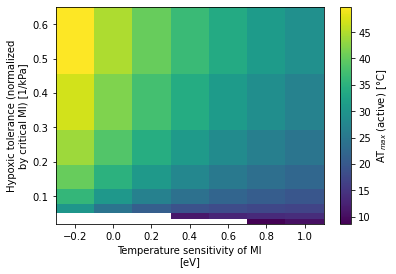

In [20]:
dso.ATmax_active.plot();

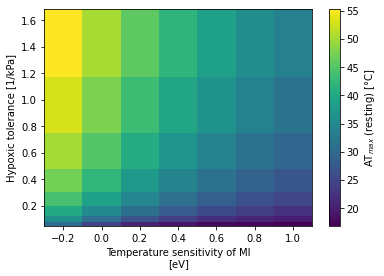

In [21]:
dso.ATmax_resting.plot();

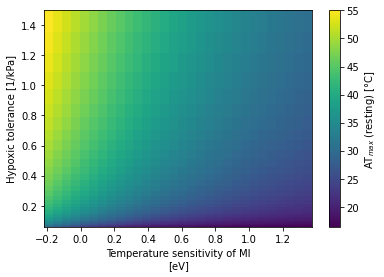

In [22]:
dso_hires.ATmax_resting.plot()

## Write out cached trait-space data

In [23]:
clobber = True

this_notebook = 'trait-space-joint-pdf.ipynb'

curator = util.curator_local_assets()

if clobber:
    cache_file = 'data/cache/trait-space.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    dso.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key='trait-space',
        urlpath=cache_file,
        description=f'Idealized trait space generated by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )

    cache_file = 'data/cache/trait-space-hires.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    dso_hires.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key='trait-space-hires',
        urlpath=cache_file,
        description=f'Idealized trait space generated by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )

cat = curator.open_catalog()
ds_cache = cat['trait-space'].to_dask()
xr.testing.assert_identical(dso, ds_cache)

cat = curator.open_catalog()
ds_cache = cat['trait-space-hires'].to_dask()
xr.testing.assert_identical(dso_hires, ds_cache)

In [24]:
dso.info()

xarray.Dataset {
dimensions:
	Ac = 8 ;
	Eo = 7 ;
	Ao = 8 ;

variables:
	float64 Ac(Ac) ;
		Ac:long_name = Hypoxic tolerance (normalized by critical MI) ;
		Ac:units = 1/kPa ;
	float64 Eo(Eo) ;
		Eo:long_name = Temperature sensitivity of MI ;
		Eo:units = eV ;
	float64 trait_spc_active(Ac, Eo) ;
		trait_spc_active:long_name = Trait density (active) ;
		trait_spc_active:units = eV 1/kPa ;
		trait_spc_active:metabolic_baseline = active ;
		trait_spc_active:N_traits = 56 ;
	float64 Ao(Ao) ;
		Ao:long_name = Hypoxic tolerance ;
		Ao:units = 1/kPa ;
	float64 trait_spc_resting(Ao, Eo) ;
		trait_spc_resting:long_name = Trait density (resting) ;
		trait_spc_resting:units = eV 1/kPa ;
		trait_spc_resting:metabolic_baseline = resting ;
		trait_spc_resting:N_traits = 56 ;
	float64 ATmax_active(Ac, Eo) ;
		ATmax_active:long_name = AT$_{max}$ (active) ;
		ATmax_active:units = °C ;
		ATmax_active:metabolic_baseline = active ;
		ATmax_active:N_traits = 56 ;
		ATmax_active:note = computed using dEodT =

In [25]:
dso_hires.info()

xarray.Dataset {
dimensions:
	Ac = 30 ;
	Eo = 30 ;
	Ao = 30 ;

variables:
	float64 Ac(Ac) ;
		Ac:long_name = Hypoxic tolerance (normalized by critical MI) ;
		Ac:units = 1/kPa ;
	float64 Eo(Eo) ;
		Eo:long_name = Temperature sensitivity of MI ;
		Eo:units = eV ;
	float64 trait_spc_active(Ac, Eo) ;
		trait_spc_active:long_name = Trait density (active) ;
		trait_spc_active:units = eV 1/kPa ;
		trait_spc_active:metabolic_baseline = active ;
		trait_spc_active:N_traits = 900 ;
	float64 Ao(Ao) ;
		Ao:long_name = Hypoxic tolerance ;
		Ao:units = 1/kPa ;
	float64 trait_spc_resting(Ao, Eo) ;
		trait_spc_resting:long_name = Trait density (resting) ;
		trait_spc_resting:units = eV 1/kPa ;
		trait_spc_resting:metabolic_baseline = resting ;
		trait_spc_resting:N_traits = 900 ;
	float64 ATmax_active(Ac, Eo) ;
		ATmax_active:long_name = AT$_{max}$ (active) ;
		ATmax_active:units = °C ;
		ATmax_active:metabolic_baseline = active ;
		ATmax_active:N_traits = 900 ;
		ATmax_active:note = computed using d